In [148]:
import numpy as np
import pandas as pd 
from ase.io import read, write
from ase.units import Hartree,kcal,mol
kcalpmol = kcal/mol
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [194]:
hm = -np.load('./test_g2_new/GGA_HM_g2_ae.npy')
# pred = -np.load('./test_g2_new/MGGA_trial6_g2_ae.npy')
pbe = -np.load('test_g2_new/PBE_g2_ae.npy')
blyp =  -np.load('test_g2_new/GGA_PBE_ML_g2_ae.npy')
pred_smooth =  -np.load('test_g2_new/GGA_SMOOTH2_g2_ae.npy')
bayesian = -np.load('test_g2_new/GGA_X_BAYESIAN, GGA_C_PBE_g2_ae.npy')
# rpbe = -np.load('test_g2_new/GGA_X_RPBE, GGA_C_PBE_g2_ae.npy')
pbe0 = -np.load('test_g2_new/PBE0_g2_ae.npy')
# b3lyp = -np.load('test_g2_new/B3LYP_g2_ae.npy')
b3lyp = -np.load('test_g2_new/B3LYP_g2_ae.npy')
ksr_hyb = -np.load('test_g2_new/0.27274*HF + MGGA_HYB_TRIAL2_PBE0_g2_ae.npy')
# ksr_hyb_smooth = -np.load('test_g2_new/0.25899822*HF + GGA_SMOOTH_HYB_g2_ae.npy')
# ksr_meta = -np.load('test_g2_new/MGGA_META3_g2_ae.npy')
# scan = -np.load('test_g2_new/SCAN_g2_ae.npy')
mgga_hm = -np.load('test_g2_new/MGGA_HM_g2_ae.npy')
ref = np.array([a.get_potential_energy()/Hartree for a in read('../haunschild_g2/g2_97.traj',':')])

aes = {'PBE':pbe, 'BLYP':blyp, 'BAYESIAN': bayesian, 'GGA-HM':hm, 'GGA-KSR(SMOOTH)':pred_smooth, 'MGGA-HM':mgga_hm, 'PBE0':pbe0, 'B3LYP':b3lyp,
       'GGA-SMOOTH-KSR0': ksr_hyb,'CCSD(T)':ref}
# aes = {'PBE':pbe, 'BLYP':blyp, 'RPBE':rpbe, 'BAYESIAN': bayesian, 'GGA-HM':hm, 'GGA-KSR':pred,'GGA-KSR(SMOOTH)':pred_smooth,'CCSD(T)':ref}
# skip = [15, 58, 83, 2, 25, 113, 18]
# skip = [2,24,25,26]
hm_train = [15, 58, 83]
systems_train = [2, 113, 25, 18, 114, 0, 20, 26] #Training
systems_val = [103, 14, 23, 5, 10, 79, 27, 105] #Validation
skip = systems_train + systems_val + hm_train
# skip =[]
filt = np.arange(len(ref))
filt = np.delete(filt, skip)
# filt = [103, 14, 23, 5, 10, 79, 27, 105]
aes = {key:val[filt] for key,val in aes.items()}
# aes = {'PBE':pbe,'CCSD(T)':ref}
atoms = read('../haunschild_g2/g2_97.traj',':')

nelec = np.array([np.sum(a.get_atomic_numbers()) for a in atoms])

In [195]:
df_aes = pd.DataFrame(aes)*Hartree/kcalpmol

df_errors = -(df_aes.T - df_aes['CCSD(T)'].T).T

df_errors.abs().mean()

df_errors = df_errors.drop('CCSD(T)',axis=1)

df_errors = df_errors.reset_index()

df_errors = df_errors.melt('index',var_name= 'functional',value_name='Residuals (kcal/mol)').reset_index(drop='true')

In [196]:
def get_facet(df,text_x=-0.1,xlim=None, error_col='Residuals (kcal/mol)'):
    sns.set_style("darkgrid", {"axes.facecolor": "None","grid.color":"None"})
    def label(x, color, label):
        ax = plt.gca()
        if label=='PBE':
            ax.text(0.35, .65, u'\u2190 Overbinding', fontweight="bold", color='black',alpha=0.5,
                ha="center", va="center", transform=ax.transAxes)
            ax.text(0.7, .65, u'Underbinding \u2192', fontweight="bold", color='black',alpha=0.5,
                ha="center", va="center", transform=ax.transAxes)
            ax.text(text_x, .65, 'XC\n(MD,MAD)'.format(x.mean(), x.abs().mean()), fontweight="bold", color='grey',
                ha="left", va="center", transform=ax.transAxes)
            
    #     ax.text(-0.1, .2, label, fontweight="bold", color="black",
    #             ha="left", va="center", transform=ax.transAxes)
        ax.text(text_x, .2, label +'\n({:.1f},{:.1f})'.format(x.mean(), x.abs().mean()), fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)
    ridge_plot = sns.FacetGrid(df, row="functional", hue="functional", aspect=5, height=1.25)

    # Draw the densities in a few steps
    ridge_plot.map(plt.vlines, x=0,ymin=0,ymax=0.035, lw=2,ls='--',alpha=1, clip_on=False,color='black')
#     ridge_plot.map(sns.histplot, error_col,binrange=(0,0.004))
    ridge_plot.map(sns.kdeplot, error_col, clip_on=False, shade=True, alpha=0.7, lw=3, bw_method=.2)
    #g.map(sns.kdeplot, "co2_emission", clip_on=False, color="b", lw=4, bw=.2)
#     ridge_plot.map(plt.axvline, x=0, lw=3, clip_on=False)
    ridge_plot.map(plt.axhline, y=0, lw=3, clip_on=False)
#     ridge_plot.map(plt.axvline, x=0, lw=2,ls='--',alpha=0.5, clip_on=True,color='black')
    
    ridge_plot.map(label, error_col)
    # Set the subplots to overlap
    ridge_plot.fig.subplots_adjust(hspace=-0.5)
    # Remove axes details that don't play well with overlap
    ridge_plot.set_titles("")
    ridge_plot.set(yticks=[])
    #ridge_plot.set_xlabel("CO2 Emission",fontsize=30)
    ridge_plot.despine(bottom=True, left=True)
    return ridge_plot
# ridge_plot.fig.subplots_adjust(hspace=-.3)

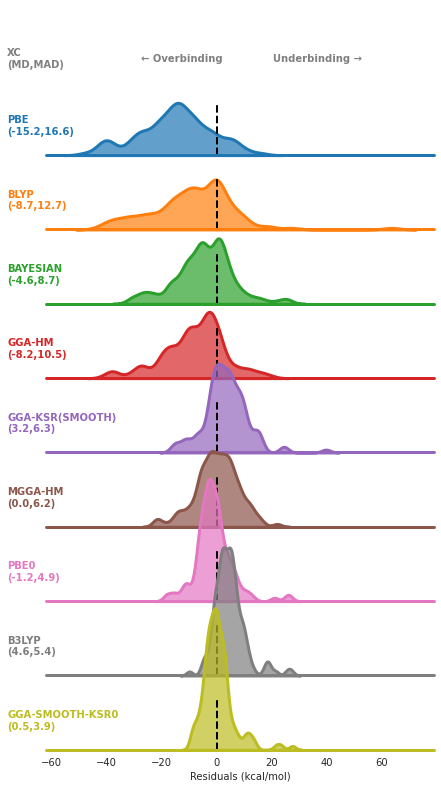

In [197]:
rp = get_facet(df_errors)

In [198]:
# if skip:
#     rp.savefig('figs/AE_novaltrain.pdf',bbox_inches='tight')
#     rp.savefig('figs/AE_novaltrain.png',bbox_inches='tight')
# else:
#     rp.savefig('figs/AE.pdf',bbox_inches='tight')
#     rp.savefig('figs/AE.png',bbox_inches='tight')

In [199]:
def get_facet_rho(df,text_x=-0.1,xlim=None,error_col = 'Density error ($ \\times 10^3$)'):
    sns.set_style("darkgrid", {"axes.facecolor": "None","grid.color":"None"})
    def label(x, color, label):
        ax = plt.gca()
        if label=='PBE':
            ax.text(text_x, .65, 'XC\n(ME,RMSE)'.format(x.mean()), fontweight="bold", color='grey',
                ha="left", va="center", transform=ax.transAxes)
            
    #     ax.text(-0.1, .2, label, fontweight="bold", color="black",
    #             ha="left", va="center", transform=ax.transAxes)
        ax.text(text_x, .2, label +'\n({:.1f},{:.1f})'.format(x.mean(),(x**2).mean()**(1/2)), fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)
        outliers = x[x>3.0]
        if len(outliers) < 7:
            outliers = x.sort_values().tail(7)
        xlims=ax.get_xlim()
        xrange = xlims[1]-xlims[0]
        heightdict={}
        for sym, x_ in outliers.items():
            xpos = (x_-xlims[0])/xrange
            xposr = np.round(x_/3)
            if not xposr in heightdict:
                heightdict[xposr] = 0.15
            else:
                heightdict[xposr] += 0.15
            ax.text(xpos, heightdict[xposr], sym, color='black',
                ha="center", va="center", transform=ax.transAxes)
#             ax.text(xpos, 0.1, sym, color='black',
#                 ha="center", va="center", transform=ax.transAxes)
    ridge_plot = sns.FacetGrid(df, row="functional", hue="functional", aspect=5, height=1.25)

    # Draw the densities in a few steps
    ridge_plot.map(plt.vlines, x=0,ymin=0,ymax=20, lw=2,ls='-',alpha=1, clip_on=False,color='black')
#     ridge_plot.map(sns.histplot, error_col,binrange=(0,4),binwidth=0.15)
    ridge_plot.map(sns.histplot, error_col,binwidth=0.15)
#     ridge_plot.map(sns.kdeplot, error_col, clip_on=False, shade=True, alpha=0.7, lw=3, bw_method=.2, clip= (0.0, .01))
    #g.map(sns.kdeplot, "co2_emission", clip_on=False, color="b", lw=4, bw=.2)
#     ridge_plot.map(plt.axvline, x=0, lw=3, clip_on=False)
    ridge_plot.map(plt.axhline, y=0, lw=3, clip_on=False)
#     ridge_plot.map(plt.axvline, x=0, lw=2,ls='--',alpha=1, clip_on=True,color='black')
    
    ridge_plot.map(label, error_col)
    # Set the subplots to overlap
    ridge_plot.fig.subplots_adjust(hspace=0.1)
    # Remove axes details that don't play well with overlap
    ridge_plot.set_titles("")
    ridge_plot.set(yticks=[])
    #ridge_plot.set_xlabel("CO2 Emission",fontsize=30)
    ridge_plot.despine(bottom=True, left=True)
    return ridge_plot
# ridge_plot.fig.subplots_adjust(hspace=-.3)

In [202]:
dir_ = 'test_g2_new'
# dir_ = 'test_g2'
erho = {
# 'HM': np.load(dir_ + '/GGA_HM_errors_rho.npy'),

'PBE' : np.load(dir_ +'/PBE_errors_rho.npy'),
'BLYP' :  np.load(dir_ +'/BLYP_errors_rho.npy'),
'BAYESIAN' : np.load(dir_ +'/GGA_X_BAYESIAN, GGA_C_PBE_errors_rho.npy'),
'GGA-HM' : np.load(dir_ + '/GGA_HM_errors_rho.npy'),
# 'GGA-KSR1' : np.load('test_g2_nomag/GGA_SMOOTH_errors_rho.npy'),  
'GGA-KSR2' : np.load(dir_ + '/GGA_SMOOTH2_errors_rho.npy'),  
'MGGA-HM' : np.load(dir_ + '/MGGA_HM_errors_rho.npy'),
'PBE0' :  np.load(dir_ + '/PBE0_errors_rho.npy'),
'B3LYP' :  np.load(dir_ + '/B3LYP_errors_rho.npy'),
'GGA-KSR0' : np.load(dir_ + '/0.2500*HF + GGA_SMOOTH_HYB3,_errors_rho.npy'),
# 'GGA-SMOOTH-KSR0' : np.load(dir_ + '/0.25899822*HF + GGA_SMOOTH_HYB_errors_rho.npy'),
#  '' = np.load('/MGGA_META3_errors_rho.npy')
# scan = -np.load('test_g2/SCAN_errors_rho.npy')
}
erho = {key:val[filt] for key,val in erho.items() }
df_erho = pd.DataFrame(erho)

df_errors = pd.DataFrame(erho)*1000



In [203]:
df_errors.index = [str(a.symbols) for idx,a in enumerate(atoms) if not idx in skip]

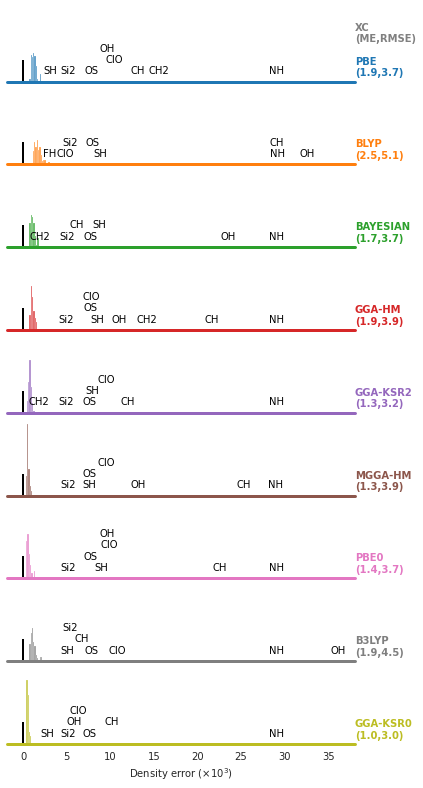

In [204]:
df_errors = df_errors.reset_index()

df_errors = df_errors.melt('index',var_name= 'functional',value_name='Density error ($ \\times 10^3$)').reset_index(drop='true')

rp=get_facet_rho(df_errors.set_index('index'),text_x=1)

In [15]:
# if skip:
#     rp.savefig('figs/rhotot_novaltrain.pdf',bbox_inches='tight')
#     rp.savefig('figs/rhotot_novaltrain.png',bbox_inches='tight')
# else:
#     rp.savefig('figs/rhotot.pdf',bbox_inches='tight')
#     rp.savefig('figs/rhotot.png',bbox_inches='tight')

In [14]:
# hm = np.load('./test_bh76/MGGA_trial6_bh76.npy')
# pred = -np.load('./test_bh76/')
# pbe = -np.load('test_g2/PBE_g2_ae.npy')
# blyp =  -np.load('test_g2/BLYP_g2_ae.npy')
# bayesian = -np.load('test_g2/GGA_X_BAYESIAN, GGA_C_PBE_g2_ae.npy')
# rpbe = -np.load('test_g2/GGA_X_RPBE, GGA_C_PBE_g2_ae.npy')
# pbe0 = -np.load('test_g2/PBE0_g2_ae.npy')
# b3lyp = -np.load('test_g2/B3LYP_g2_ae.npy')
# # scan = -np.load('test_g2/SCAN_g2_ae.npy')
# ref = np.array([a.get_potential_energy()/Hartree for a in read('../haunschild_g2/g2_97.traj',':')])

# np.load('./test_bh76/.npynpy')
keys = ['PBE','GGA_X_RPBE, GGA_C_PBE','BLYP','GGA_X_BAYESIAN, GGA_C_PBE','GGA_HM','MGGA_trial6','GGA_SMOOTH','GGA_SMOOTH2','PBE0','B3LYP',
        '0.27274*HF + MGGA_HYB_TRIAL2_pbe0,', '0.25899822*HF + GGA_SMOOTH_HYB','wb97x']
aes = {key: np.load('./test_bh76/{}_bh76.npy'.format(key))*kcalpmol/Hartree for key in keys}
aes['CCSD(T)'] = np.load('./test_bh76/bh76.npy')*kcalpmol/Hartree
# skip = [15, 58, 83, 2, 25, 113, 18]
# skip = [2,24,25,26]
skip =[]
filt = np.arange(len(aes['CCSD(T)']))
filt = np.delete(filt, skip)

aes = {key:val[filt] for key,val in aes.items()}
# aes = {'PBE':pbe,'CCSD(T)':ref}
atoms = read('../haunschild_g2/g2_97.traj',':')

nelec = np.array([np.sum(a.get_atomic_numbers()) for a in atoms])

df_aes = pd.DataFrame(aes)*Hartree/kcalpmol
df_aes = df_aes.rename({'GGA_X_RPBE, GGA_C_PBE':'RPBE','GGA_X_BAYESIAN, GGA_C_PBE':'BAYESIAN',
                        'MGGA_trial6':'GGA-KSR','0.27274*HF + MGGA_HYB_TRIAL2_pbe0,':'GGA-KSR0'},axis=1)
df_errors = -(df_aes.T - df_aes['CCSD(T)'].T).T

df_errors.abs().mean()

df_errors = df_errors.drop('CCSD(T)',axis=1)

df_errors = df_errors.reset_index()

df_errors = df_errors.melt('index',var_name= 'functional',value_name='Residuals (kcal/mol)').reset_index(drop='true')

FileNotFoundError: [Errno 2] No such file or directory: './test_bh76/0.25899822*HF + GGA_SMOOTH_HYB_bh76.npy'

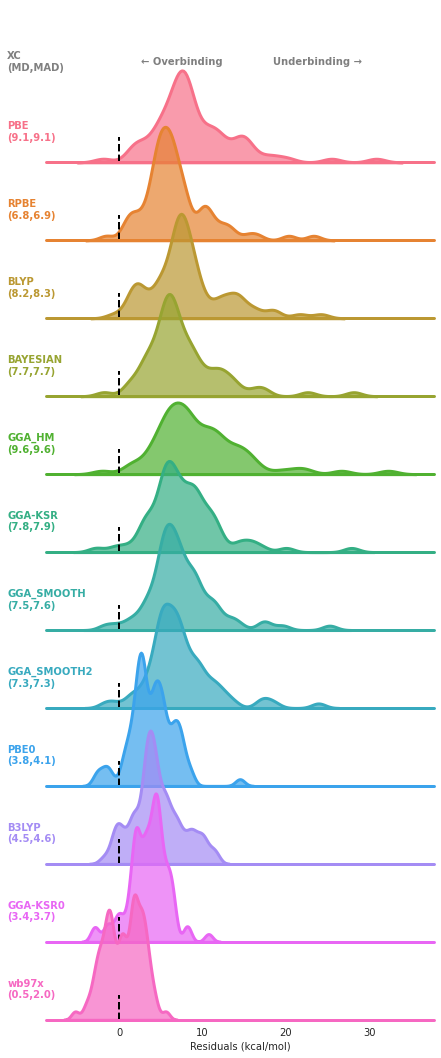

In [19]:
rp = get_facet(df_errors)

In [222]:
if skip:
    rp.savefig('figs/BH_novaltrain.pdf',bbox_inches='tight')
    rp.savefig('figs/BH_novaltrain.png',bbox_inches='tight')
else:
    rp.savefig('figs/BH.pdf',bbox_inches='tight')
    rp.savefig('figs/BH.png',bbox_inches='tight')

In [17]:
hm_error = np.abs(ref - hm)
pbe_error = np.abs(ref - pbe)
pred_error = np.abs(ref - pred)
dhm = pbe_error - hm_error
dpred = pbe_error - pred_error

In [32]:
highlight = np.arange(len(dpred))
np.random.shuffle(highlight)
highlight = highlight[:10]

NameError: name 'dhm' is not defined

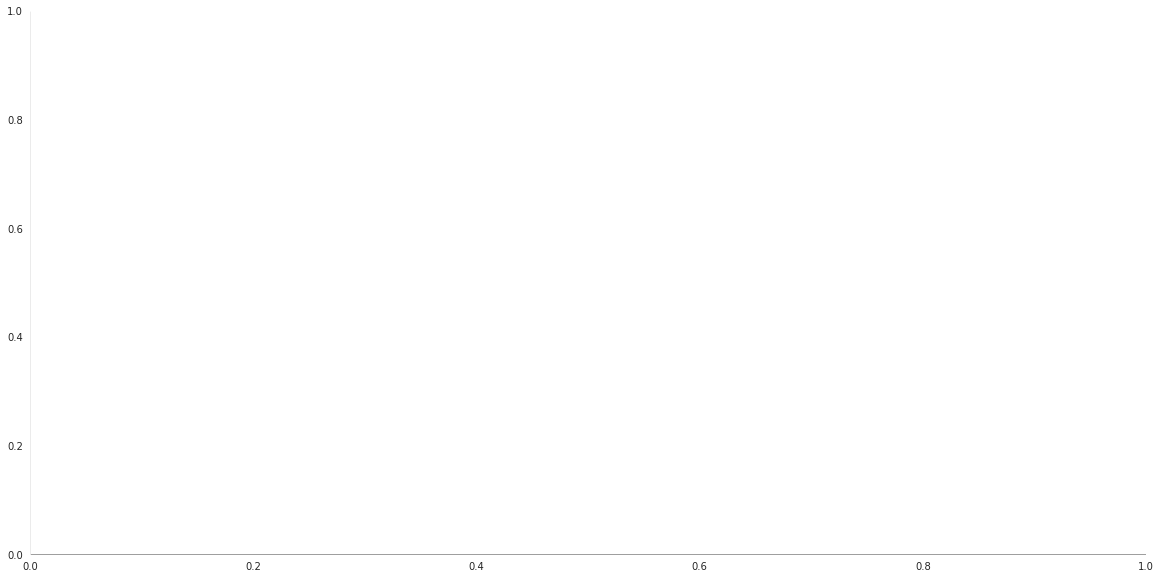

In [118]:
figsize(20,10)
axhline(0, color='gray')
axvline(0, color='gray')
plot(dhm, dpred,ls='',marker='.')
plot([-0.08,0.06],[-0.08,.06], ls='--')
for idx, (h,p) in enumerate(zip(dhm,dpred)):
    c = 'black'
    if idx in highlight:
        c ='red'
    text(h,p,idx, color=c)
xlim(-0.02,0.05);  

In [145]:
class T():
    def __init__(self):
        self.a = 0
    def __getattribute__(self, name):

        return super().__getattribute__(name)


In [146]:
t = T()

In [147]:
t.a

0